# Support Vector Machine

Notebook adapted and inspired from: https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb

In [1]:
# some imports
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Linear SVM CLASSIFICATION

The key idea from the LINEAR Classifier is as follows: **Among all separating hyperplanes, find the one that makes the biggest gap or margin between the two classes.**
![](https://cdn-images-1.medium.com/max/2000/1*nUpw5agP-Vefm4Uinteq-A.png)


If $f (X) = \beta_0 + \beta_1X_1 + ... + \beta_pX_p$ , then $f(X) > 0$ for points on one side of the hyperplane, and $f(X) < 0$ for points on the other.

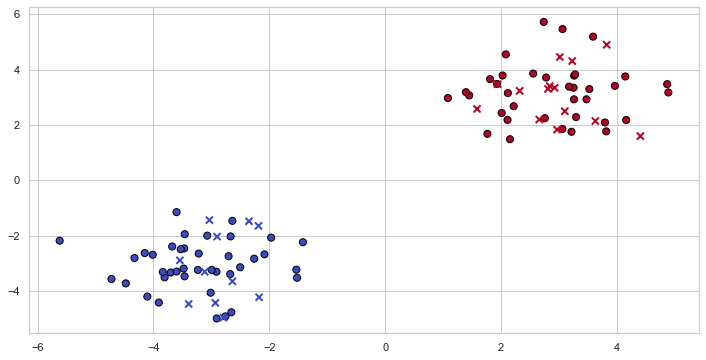

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


plt.figure(figsize=(12,6))
X, y = make_blobs(n_features=2, centers=[(-3,-3),(3,3)])
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state = 44)

plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c=y_train, s=50, edgecolor='k',cmap='coolwarm')
plt.scatter(X_val[:, 0], X_val[:, 1], marker='x', c=y_val, s=50, edgecolor='k',cmap='coolwarm')
plt.show()

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.datasets import make_blobs


class HLA():
    def __init__(self):
        self.X, self.y = make_blobs(n_features=2, centers=[(-3,-3),(3,3)],random_state=1)
        delta = 0.025
        xx = np.arange(-6.0, 6.0, delta)
        yy = np.arange(-6.0, 6.0, delta)
        XX, YY = np.meshgrid(xx, yy)
        Xf = XX.flatten()
        Yf = YY.flatten()
        self.sz = XX.shape
        self.data = np.concatenate([Xf[:,np.newaxis],Yf[:,np.newaxis]],axis=1);

    
    def run(self,w0,w1,offset):
        w = np.array([w0,w1])
        w.shape = (2,1)
        Z = self.data.dot(w)+offset
        Z.shape=self.sz
        plt.scatter(self.X[:, 0], self.X[:, 1], marker='o', c=self.y, s=50, edgecolor='k',cmap='coolwarm')
        
        plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-6,6,-6,6),alpha=0.3, vmin=-30, vmax=30,cmap='coolwarm')
        XX = self.data[:,0].reshape(self.sz)
        YY = self.data[:,1].reshape(self.sz)
        plt.contour(XX,YY,Z,[0])
        fig = plt.gcf()
        fig.set_size_inches(9,9)
        
        
def decorator(w0,w1,offset):
    widget_hla.run(w0,w1,offset)
    
widget_hla = HLA()
interact(decorator, w0=(-5.,5.), w1=(-5.,5.), offset=(-10.,10.));

interactive(children=(FloatSlider(value=0.0, description='w0', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…

## Hard-Margin
Constrained optimization problem
$$ \mathop{maximize_{\beta_0,...,\beta_p}} M \\
 subject~to \sum_{j=1}^p \beta_j^2 =1, \\
 y_i(\beta_0 + \beta_1x_{i1} + ... + \beta_px_{ip}) \geq M \\
 for~all ~~i= 1,…,N$$
<br>
<br>
The previous formulation is equivalent to:
$$ minimize_{\beta_0,...,\beta_p} \| \mathbf{\beta} \|^2 \\
subject~to~   y_i(\beta_0 + \beta_1x_{i1} + ... + \beta_px_{ip}) \geq 1\\
for~all ~~i= 1,...,N$$

which is easy to normalize (differenciable and convex) using standard methods.


In [4]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, kernel='linear')

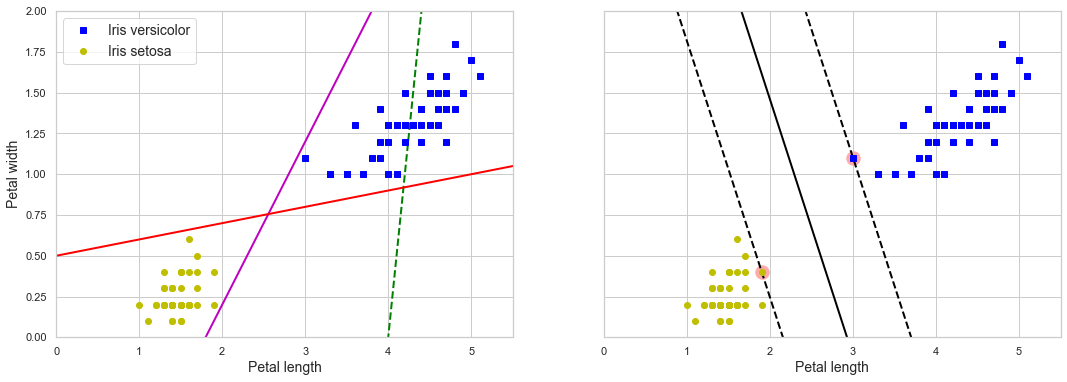

In [5]:
# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(18,6), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

### Sensitivity to feature scales

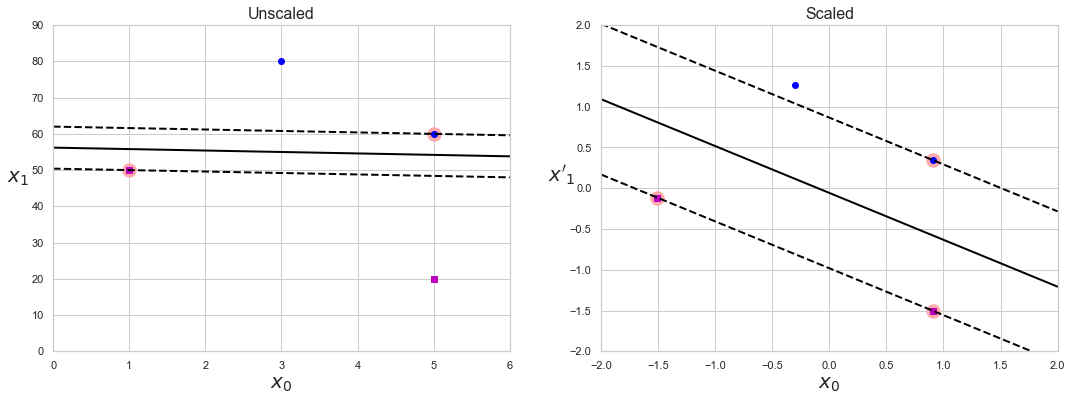

In [6]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

plt.show()

### Sensitivity to outliers

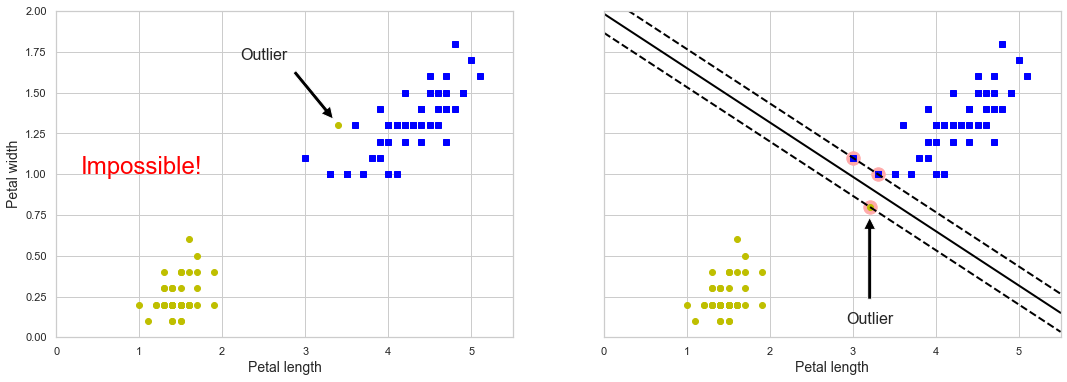

In [7]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(18,6), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.show()

## SOFT MARGIN

Now the main goal is to find a hyperplane that separates +ve and -ve examples with the largest margin while keeping the misclassification as low as possible.

The minimization probles is translated to:

$$  min_{\textbf{w},\xi}\frac{1}{2} \|\textbf{w}\| + \frac{C}{N}\sum_i\xi$$
$$ s.t.~y_i (\textbf{w} \cdot \textbf{x}_i ) \geq 1 -\xi_i,\xi\geq0,\forall i \in \{1,...,N \}$$

We will minimize the cost/objective function shown below: 
$$ J(\mathbf{w}) = \frac{1}{2}\|\mathbf{w}\|^2 +\frac{C}{N} \sum_{i}^{n}max(0,1 - y_i*(\mathbf{w}\cdot x_i + b))  $$

In [8]:
def loss(W, x, y, C):
    return 1/2 * np.sum(W**2) + C * np.sum([np.max([0, 1 - y[i] * (W @ x[i])]) for i in range(x.shape[0])])



# Example loss
w = np.array([1,2,2]) # hyperplance
x = np.array([[1,2,2], [2,4,4], [9.5, 5, 6]]) # points to classify
y = np.array([-1, 1, -1]) # labels
c = 0.5 # the smaller this value, the larger will be the margin of the SVM model
print(f'Loss {loss(w, x, y, c)}')

Loss 25.75


Now, we need a function for to compute the gradient

In [9]:
def loss_gradient(W, x, y, C):
    '''
    Loss gradient for SGD with batch size 1 only
    '''
    lossGrad = np.zeros_like(W)
    distance = np.max([0, 1 - y * (W @ x)])
    
    if distance == 0:
        lossGrad = W
    else:
        lossGrad = W - C * y * x
            
    return lossGrad

Current loss 0.2773995439094052  Step  0
Current loss 0.29995747365023023  Step  10
Current loss 0.22221062850308862  Step  20
Current loss 0.2557271084876683  Step  30
Current loss 0.2860158510480844  Step  40
Current loss 0.3244811420838137  Step  50
Current loss 0.2403779363868139  Step  60
Current loss 0.2773656980337279  Step  70
Current loss 0.3109413577950291  Step  80
Current loss 0.230347567948269  Step  90
Current loss 0.27059517702752217  Step  100
Current loss 0.29975587891931005  Step  110
Current loss 0.2220612856935391  Step  120
Current loss 0.25889278232796753  Step  130
Current loss 0.29096901787599655  Step  140
Current loss 0.21555191657783204  Step  150
Current loss 0.24594229773032372  Step  160
Current loss 0.2842962156450177  Step  170
Current loss 0.3195429229602516  Step  180
Current loss 0.23671966856044854  Step  190

Optimized weights [0.66807827 0.35593173 0.01938563]
2.8095275326824094


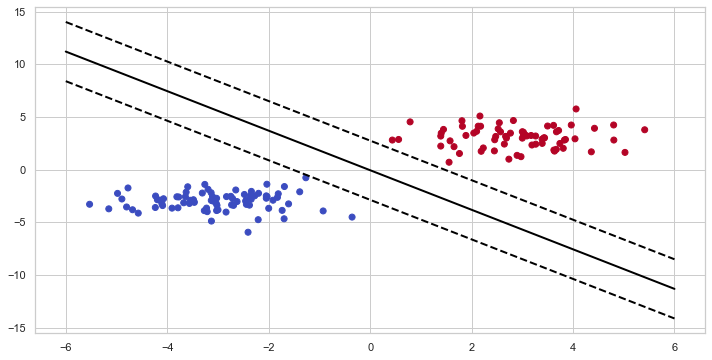

In [67]:
## Prepare data fro the SVM training
### random weights
W = np.random.random(X_train.shape[1] + 1)
X_ = np.hstack([X_train, 
                np.ones(X_train.shape[0]).reshape(-1,1)])
y_ = (y_train*2-1).copy()
W

## defind parameters
N_STEPS = 200
lr = 1e-4
C = 1e3

## stochastic gradient descend
for step in range(N_STEPS):
    for pi,p in enumerate(X_):
        W = W - lr * loss_gradient(W, p, y_[pi], C = C)
    if(step % 10 ==0):
        print("Current loss",loss(W, X_, y_, C)," Step ",step)
        
print("\nOptimized weights", W)

plt.figure(figsize=(12,6))
plt.scatter(X_[:,0],X_[:,1],c = y_,cmap='coolwarm')

x0 = np.linspace(-6, 6, 200)
decision_boundary = -W[0]/W[1] * x0 - W[2]/W[1]
margin = 1/W[1]
print(margin)

gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin

plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.show()


In [68]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X_train, y_train)

SVC(C=10000000000.0, kernel='linear')

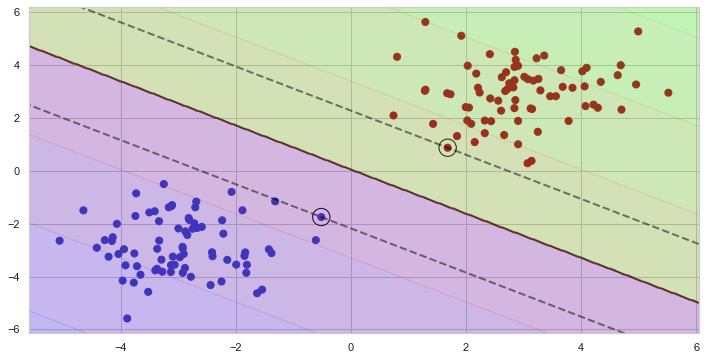

In [111]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 200)
    y = np.linspace(ylim[0], ylim[1], 200)
    
    Y, X = np.meshgrid(y, x)
    
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none',edgecolors='black');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    y_pred = model.predict(xy).reshape(X.shape)
    y_decision = model.decision_function(xy).reshape(X.shape)
    ax.contourf(X, Y, y_pred, cmap=plt.cm.brg, alpha=0.2)
    ax.contourf(X, Y, y_decision, cmap=plt.cm.brg, alpha=0.1)
    
    
plt.figure(figsize=(12,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='coolwarm')
plot_svc_decision_function(model);

plt.show()

We can see the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure. These points are the pivotal elements of this fit, and are known as the ``support vectors``
, and give the algorithm its name. In Scikit-Learn, the identity of these points are stored in the support_vectors_ attribute of the classifier:

In [112]:
model.support_vectors_

array([[-0.51503005, -1.74738428],
       [ 1.67907469,  0.87631698]])

A importat point to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit! 
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 75 points and first 150 points of this dataset:

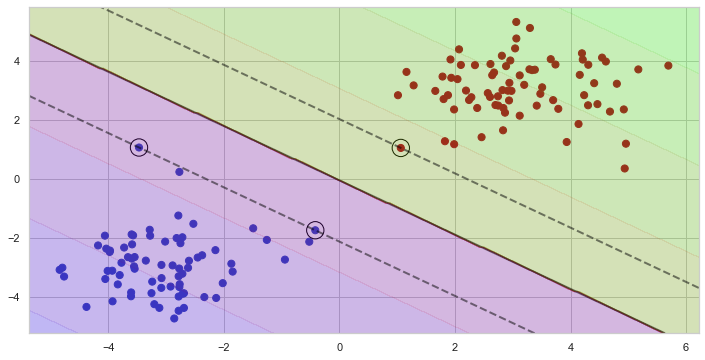

In [113]:
X, y = make_blobs(n_features=2, centers=[(-3,-3),(3,3)],n_samples = 200)
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state = 44)


model = SVC(kernel='linear', C=1E10)
model.fit(X_train, y_train)


plt.figure(figsize=(12,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='coolwarm')
plot_svc_decision_function(model);

plt.show()

## Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with kernels

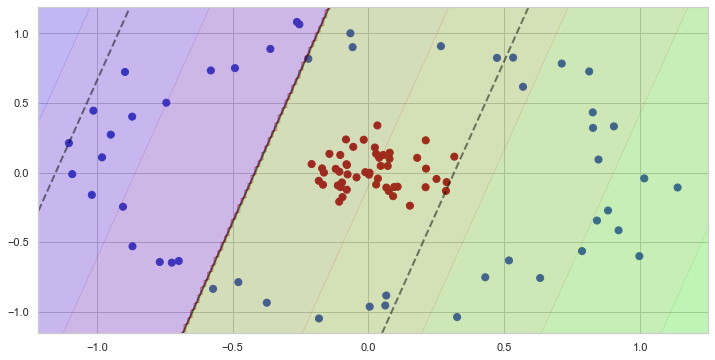

In [114]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.figure(figsize=(12,6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
plot_svc_decision_function(clf, plot_support=False);

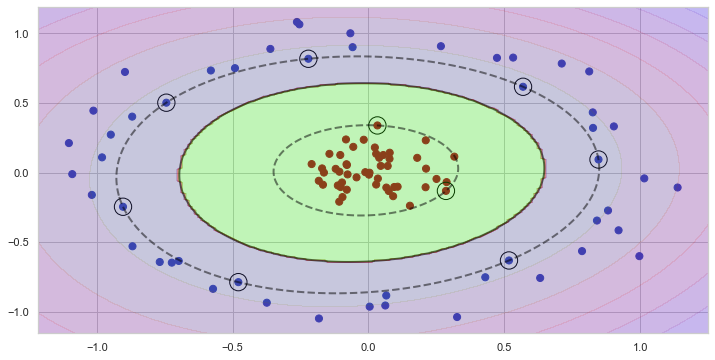

In [115]:
clf = SVC(kernel='poly', degree=3, coef0=1 , C=1E6)
clf.fit(X, y)


plt.figure(figsize=(12,6))


plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

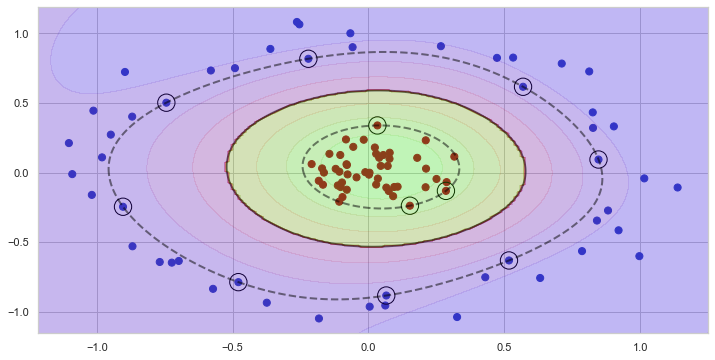

In [116]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)


plt.figure(figsize=(12,6))


plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

In [117]:
## TUNE HYPERPARAMETERS

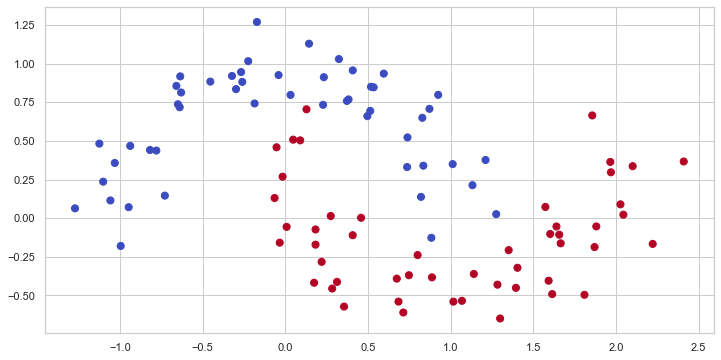

In [118]:

from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
plt.figure(figsize=(12,6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')


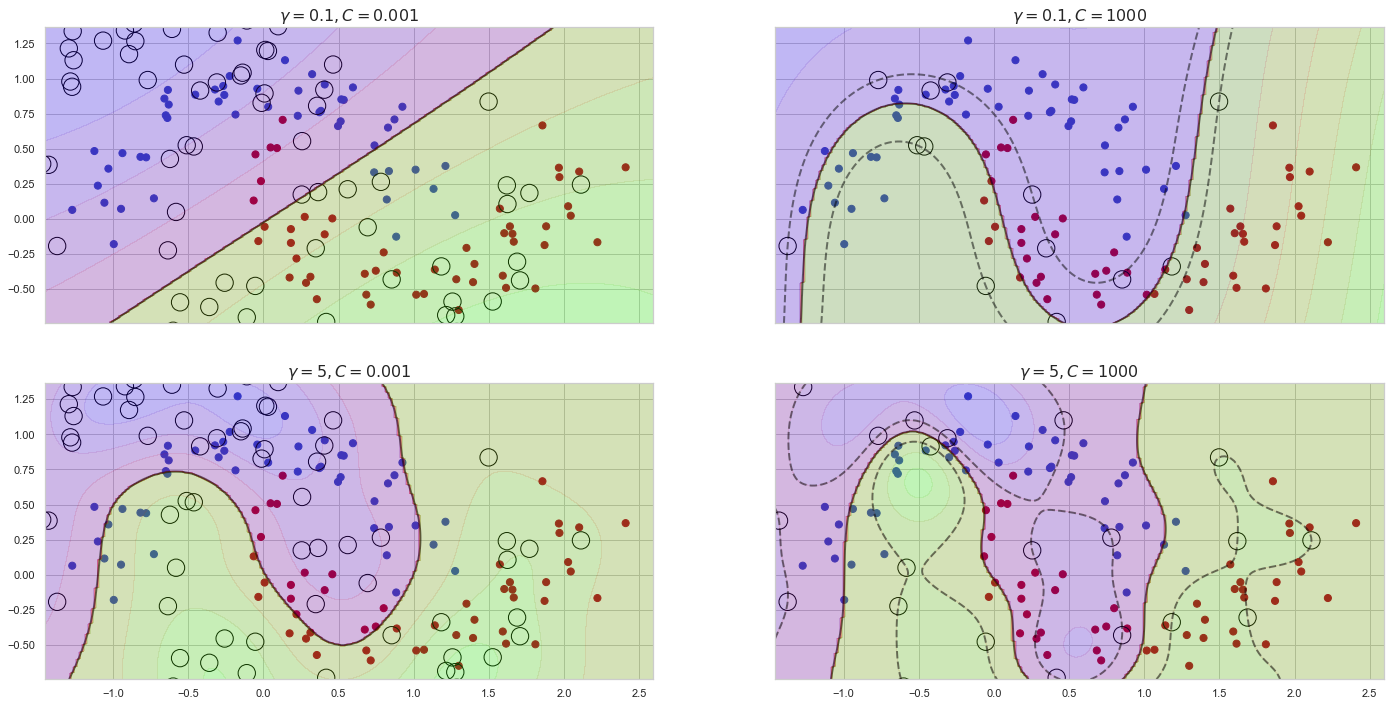

In [119]:
from sklearn.pipeline import Pipeline

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12), sharex=True, sharey=True)


for i, svm_clf in enumerate(svm_clfs):
    
    clf = svm_clf['svm_clf']
    plt.sca(axes[i // 2, i % 2])
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
    plot_svc_decision_function(clf)
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

    gamma, C = hyperparams[i]
    
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()